# Non-Parametric Tests Part II

Up until now, you've been using standard hypothesis tests on means of normal distributions to design and analyze experiments. However, it's possible that you might encounter scenarios where you can't rely on only standard tests. This might be due to uncertainty about the true variability of a metric's distribution, a lack of data to assume normality, or wanting to do inference on a statistic that lacks a standard test. It's useful to know about some **non-parametric tests** not just as a workaround for cases like this, but also as a second check on your experimental results.

In [33]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
# % matplotlib inline

## Rank-Sum Test (Mann-Whitney)

The rank-sum test is fairly different from the two previous approaches. There's no resampling involved; the test is performed only on the data present. The rank-sum test, also known as the Mann-Whitney U test, is not a test of any particular statistic, like the mean or median. Instead, it's a test of distributions: let's say we draw one value at random from the populations behind each group. The null hypothesis says that there's an equal chance that the larger value is from the first group as the second group; the alternative hypothesis says that there's an unequal chance, which can be specified as one- or two-tailed.

In order to test this hypothesis, we should look at the data we've collected and see in how many cases values from one group win compared to values in the second. That is, for each data point in the first group, we count how many values in the second group that are smaller than it. (If both values are equal, we count that as a tie, worth +0.5 to the tally.) This number of wins for the first group gives us a value $U$.

It turns out that $U$ is approximately normally-distributed, given a large enough sample size. If we have $n_1$ data points in the first group and $n_2$ points in the second, then we have a total of $n_1 n_2$ matchups and an equivalent number of victory points to hand out. Under the null hypothesis, we should expect the number of wins to be evenly distributed between groups, and so the expected wins are:
$$\mu_U = \frac{n_1 n_2}{2}$$
The variability in the number of wins can be found to be the following equation (assuming no or few ties):
$$ 
\sigma_U = \sqrt{\frac{n_1n_2(n_1+n_2+1)}{12}}
$$

These $\mu_U$ and $\sigma_U$ values can then be used to compute a standard normal z-score, which generates a p-value. Implement this method of performing the rank-sum test in the cells below!

- HINT: scipy stats' [`norm`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) class can be used to obtain p-values after computing a z-score.

In [34]:
def ranked_sum(x, y, alternative = 'two-sided'):
    """
    Return a p-value for a ranked-sum test, assuming no ties.
    
    Input parameters:
        x: 1-D array-like of data for first group
        y: 1-D array-like of data for second group
        alternative: type of test to perform, {'two-sided', less', 'greater'}
    
    Output value:
        p: estimated p-value of test
    """
    
    # compute U
    u = 0
    for i in x:
        wins = (i > y).sum()
        ties = (i == y).sum()
        u += wins + 0.5 * ties
    
    # compute a z-score
    n_1 = x.shape[0]
    n_2 = y.shape[0]
    mean_u = n_1 * n_2 / 2
    sd_u = np.sqrt( n_1 * n_2 * (n_1 + n_2 + 1) / 12 )
    z = (u - mean_u) / sd_u
    
    # compute a p-value
    if alternative == 'two-sided':
        p = 2 * stats.norm.cdf(-np.abs(z))
    if alternative == 'less':
        p = stats.norm.cdf(z)
    elif alternative == 'greater':
        p = stats.norm.cdf(-z)
    
    return p

In [35]:
data = pd.read_csv('../data/permutation_data.csv')
data.head()

,condition,time
0,0,5940
1,0,666
2,1,571
3,1,779
4,0,1928


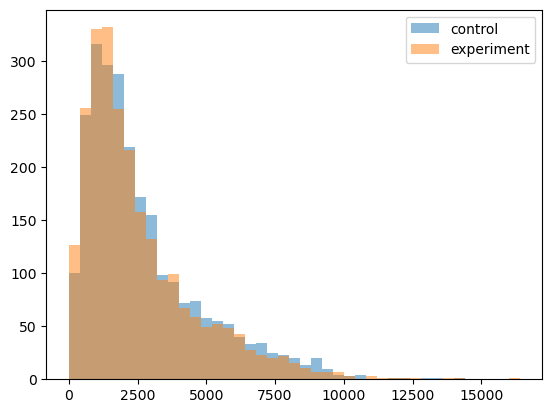

In [36]:
# data visualization
bin_borders = np.arange(0, data['time'].max()+400, 400)
plt.hist(data[data['condition'] == 0]['time'], alpha = 0.5, bins = bin_borders)
plt.hist(data[data['condition'] == 1]['time'], alpha = 0.5, bins = bin_borders)
plt.legend(labels = ['control', 'experiment']);

In [37]:
ranked_sum(data[data['condition'] == 0]['time'],
           data[data['condition'] == 1]['time'],
           alternative = 'two-sided')

0.003504453004592212

### Rank-Sum Test Notes

For smaller sample sizes, something like the permutation test can be performed. After exhaustively checking the distribution of victories for every possible assignment of group labels to value, a p-value can be computed for how unusual the actually-observed $U$ was.

Also, there already exists a function in the scipy stats package [`mannwhitneyu`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) that performs the Mann Whitney U test. This function considers more factors than the implementation above, including a correction on the standard deviation for ties and a continuity correction (since we're approximating a discretely-valued distribution with a continuous one). In addition, the approach they take is computationally more efficient, based on the sum of value ranks (hence the rank-sum test name) rather than the matchups explanation provided above.

Reference: [Wikipedia](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)



In [38]:
stats.mannwhitneyu(data[data['condition'] == 0]['time'],
                   data[data['condition'] == 1]['time'],
                   alternative = 'greater')

MannwhitneyuResult(statistic=3273546.0, pvalue=0.001752280226004597)

## Sign Test

The sign test also only uses the collected data to compute a test result. It only requires that there be paired values between two groups to compare, and tests whether one group's values tend to be higher than the other's.

In the sign test, we don't care how large differences are between groups, only which group takes a larger value. So a comparison of 0.21 vs. 0.22 and 0.21 vs. 0.31 are both counted equally as a point in favor of the second group. This makes the sign test a fairly weak test, though also a test that can be applied fairly broadly. It's most useful when we have very few observations to draw from and can't make a good assumption of underlying distribution characteristics. For example, you might use a sign test as an additional check on click rates that have been aggregated on a daily basis.

The count of victories for a particular group can be modeled with the binomial distribution. Under the null hypothesis, it is equally likely that either group has a larger value (in the case of a tie, we ignore the comparison): the binomial distribution's success parameter is $p = 0.5$. Implement the sign test in the function below!

- HINT: scipy stats' [`binom`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html) class can be used to obtain p-values after computing the number of matchups and victories.

In [39]:
def sign_test(x, y, alternative = 'two-sided'):
    """
    Return a p-value for a ranked-sum test, assuming no ties.
    
    Input parameters:
        x: 1-D array-like of data for first group
        y: 1-D array-like of data for second group
        alternative: type of test to perform, {'two-sided', less', 'greater'}
    
    Output value:
        p: estimated p-value of test
    """
    
    # compute parameters
    n = x.shape[0] - (x == y).sum()
    k = (x > y).sum() - (x == y).sum()

    # compute a p-value
    if alternative == 'two-sided':
        p = min(1, 2 * stats.binom(n, 0.5).cdf(min(k, n-k)))
    if alternative == 'less':
        p = stats.binom(n, 0.5).cdf(k)
    elif alternative == 'greater':
        p = stats.binom(n, 0.5).cdf(n-k)
    
    return p

In [40]:
data = pd.read_csv('../data/signtest_data.csv')
data.head(10)

,day,control,exp
0,1,0.09610,0.09715
1,2,0.07357,0.06954
2,3,0.10030,0.08782
3,4,0.07225,0.06936
4,5,0.06173,0.09893
5,6,0.07736,0.08050
6,7,0.07121,0.11161
7,8,0.08207,0.10802
8,9,0.10602,0.08793
9,10,0.10000,0.12043


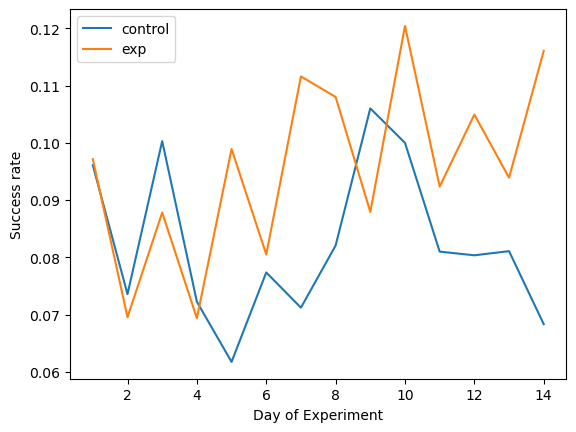

In [43]:
# data visualization
plt.plot(data['day'], data['control'], label='control')
plt.plot(data['day'], data['exp'], label='exp')
plt.legend()

plt.xlabel('Day of Experiment')
plt.ylabel('Success rate');

In [42]:
sign_test(data['control'], data['exp'], 'less')

0.08978271484375